In [1]:
import pandas as pd

## Get measurements from CSV

In [2]:
sensor_readings = pd.read_csv("D:\Master\Thesis\Code\LeakDB\LeakDB-master\measurements\measurements_1_LeakDB.csv")

sensor_readings['Timestamp'] = pd.to_datetime(sensor_readings['Timestamp'])

# Extract entity ID and type
sensor_readings['entity_id'] = sensor_readings['sensor_id'].apply(lambda x: "_".join(x.split("_")[:2]))  # e.g., Node_1 or Pipe_12
sensor_readings['measurement_type'] = sensor_readings['sensor_type']  # demand, pressure, flow
sensor_readings['entity_type'] = sensor_readings['entity_id'].apply(lambda x: x.split("_")[0])  # Node or Pipe


In [3]:
# Nodes → pressure & demand
node_df = sensor_readings[sensor_readings['entity_type'] == 'Node']
node_pivot = node_df.pivot_table(index='Timestamp', columns=['entity_id', 'measurement_type'], values='measurement')

# Pipes → flow
pipe_df = sensor_readings[sensor_readings['entity_type'] == 'Link']
pipe_pivot = pipe_df.pivot_table(index='Timestamp', columns=['entity_id', 'measurement_type'], values='measurement')

# Rewrite column names
node_pivot.columns = ['_'.join(col).strip() for col in node_pivot.columns.values]
pipe_pivot.columns = ['_'.join(col).strip() for col in pipe_pivot.columns.values]


In [4]:
pipe_pivot

,Link_1_flow,Link_10_flow,Link_11_flow,Link_12_flow,Link_13_flow,Link_14_flow,Link_15_flow,Link_16_flow,Link_17_flow,Link_18_flow,...,Link_31_flow,Link_32_flow,Link_33_flow,Link_34_flow,Link_4_flow,Link_5_flow,Link_6_flow,Link_7_flow,Link_8_flow,Link_9_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,3405.6,352.8,270.0,172.8,190.8,82.8,39.6,68.4,-212.4,-489.6,...,25.2,-36.0,54.0,198.0,1378.8,1234.8,1040.4,824.4,716.4,630.0
2017-01-01 00:30:00,2970.0,295.2,230.4,144.0,172.8,75.6,36.0,57.6,-194.4,-428.4,...,21.6,-32.4,46.8,169.2,1166.4,1054.8,900.0,723.6,615.6,543.6
2017-01-01 01:00:00,2656.8,273.6,208.8,126.0,151.2,64.8,32.4,50.4,-172.8,-388.8,...,18.0,-21.6,32.4,158.4,1054.8,957.6,802.8,640.8,561.6,493.2
2017-01-01 01:30:00,2401.2,241.2,183.6,108.0,144.0,57.6,28.8,43.2,-154.8,-363.6,...,18.0,-25.2,36.0,144.0,946.8,860.4,734.4,583.2,507.6,442.8
2017-01-01 02:00:00,2199.6,219.6,165.6,100.8,133.2,57.6,28.8,36.0,-147.6,-338.4,...,14.4,-21.6,32.4,133.2,856.8,774.0,658.8,532.8,457.2,403.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,5652.0,579.6,439.2,273.6,313.2,129.6,61.2,126.0,-352.8,-752.4,...,46.8,-64.8,90.0,342.0,2293.2,2055.6,1746.0,1353.6,1191.6,1047.6
2017-12-31 22:00:00,5360.4,554.4,421.2,273.6,298.8,129.6,68.4,126.0,-331.2,-687.6,...,39.6,-64.8,90.0,331.2,2145.6,1940.4,1641.6,1285.2,1116.0,990.0
2017-12-31 22:30:00,4935.6,518.4,399.6,255.6,270.0,111.6,54.0,115.2,-309.6,-630.0,...,32.4,-57.6,82.8,284.4,2026.8,1814.4,1526.4,1216.8,1054.8,932.4


### Separate data by feature

In [5]:
demand_cols = [col for col in node_pivot.columns if col.endswith("demand")]
pressure_cols = [col for col in node_pivot.columns if col.endswith("pressure")]

demand_df = node_pivot[demand_cols]
pressure_df = node_pivot[pressure_cols]
flow_df = pipe_pivot

## Imputation

### Split train/val, and scale

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
import joblib

def split_scale(measurements, feature, cluster):

    # Step 1: Split the full data (X_seq or X_ori) into train and validation sets
    X_train_full, X_val_full = train_test_split(measurements, test_size=0.2, shuffle = False, random_state=42)

    scaler = StandardScaler()

    # Fit and transform training data
    X_train_full_scaled = X_train_full.copy()
    X_train_full_scaled = scaler.fit_transform(X_train_full)
    X_train_full_scaled = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns, index=X_train_full.index)

    # Save scaler with specific name for later rescaling
    joblib.dump(scaler, f"{feature}_scaler_{cluster}.pkl")

    # Now, apply ONLY transformation (not fitting) on val data
    X_val_full_scaled = X_val_full.copy()
    X_val_full_scaled = scaler.transform(X_val_full)
    X_val_full_scaled = pd.DataFrame(X_val_full_scaled, columns=X_val_full.columns, index=X_val_full.index)

    return X_train_full_scaled, X_val_full_scaled, X_train_full, X_val_full

### Select semantically relevant pipes

Cluster 0: Pipe_13, Pipe_14, Pipe_15, Pipe_17, Pipe_19, Pipe_26, Pipe_27, Pipe_28, Pipe_29, Pipe_32

Cluster 1: Pipe_1, Pipe_11, Pipe_24, Pipe_3, Pipe_4, Pipe_5, Pipe_6, Pipe_7, Pipe_8, Pipe_9

Cluster 3: Pipe_10, Pipe_18, Pipe_2, Pipe_21, Pipe_22, Pipe_25, Pipe_30, Pipe_31, Pipe_33, Pipe_34

Cluster 2: Pipe_12, Pipe_16, Pipe_20, Pipe_23

In [7]:
flow_c1 = flow_df[["Link_1_flow", "Link_11_flow", "Link_24_flow", "Link_3_flow", "Link_4_flow", "Link_5_flow", "Link_6_flow", "Link_7_flow", "Link_8_flow", "Link_9_flow"]]
flow_c0 = flow_df[["Link_13_flow", "Link_14_flow", "Link_15_flow", "Link_17_flow", "Link_19_flow", "Link_26_flow", "Link_27_flow", "Link_28_flow", "Link_29_flow", "Link_32_flow"]]
flow_c3 = flow_df[["Link_10_flow", "Link_18_flow", "Link_2_flow", "Link_21_flow", "Link_22_flow", "Link_25_flow", "Link_30_flow", "Link_31_flow", "Link_33_flow", "Link_34_flow"]]
flow_c2 = flow_df[["Link_12_flow", "Link_16_flow", "Link_20_flow", "Link_23_flow"]]
flow_all = flow_df

# Initialize the containers
X_train_full_scaled = {}
X_val_full_scaled = {}
X_train_full_unscaled = {}
X_val_full_unscaled = {}
clusters = [flow_c0, flow_c1, flow_c2, flow_c3, flow_all]

# Iterate over the clusters
for i, flow_cluster in enumerate(clusters):
    X_train_full_scaled[i], X_val_full_scaled[i], X_train_full_unscaled[i], X_val_full_unscaled[i] = split_scale(flow_cluster, "flow", i)


In [8]:
X_train_full_unscaled[1]

,Link_1_flow,Link_11_flow,Link_24_flow,Link_3_flow,Link_4_flow,Link_5_flow,Link_6_flow,Link_7_flow,Link_8_flow,Link_9_flow
Timestamp,,,,,,,,,,
2017-01-01 00:00:00,3405.6,270.0,561.6,1396.8,1378.8,1234.8,1040.4,824.4,716.4,630.0
2017-01-01 00:30:00,2970.0,230.4,482.4,1180.8,1166.4,1054.8,900.0,723.6,615.6,543.6
2017-01-01 01:00:00,2656.8,208.8,435.6,1069.2,1054.8,957.6,802.8,640.8,561.6,493.2
2017-01-01 01:30:00,2401.2,183.6,385.2,957.6,946.8,860.4,734.4,583.2,507.6,442.8
2017-01-01 02:00:00,2199.6,165.6,363.6,867.6,856.8,774.0,658.8,532.8,457.2,403.2
...,...,...,...,...,...,...,...,...,...,...
2017-10-19 21:30:00,5464.8,406.8,900.0,2152.8,2124.0,1904.4,1627.2,1296.0,1137.6,1000.8
2017-10-19 22:00:00,5151.6,414.0,853.2,2077.2,2044.8,1850.4,1566.0,1260.0,1090.8,968.4
2017-10-19 22:30:00,4870.8,396.0,795.6,1998.0,1969.2,1771.2,1501.2,1202.4,1047.6,914.4


### Introduce MCAR Missingness

In [9]:
from pygrinder import mcar

missing_rates = [0.05, 0.2, 0.6, 0.90]

# Training and validation sets for each cluster
X_train_incomplete = {}
X_val_incomplete = {}
train_masks = {}
val_masks = {}

for cluster_id, flow_cluster in enumerate(clusters):
    X_train_incomplete[cluster_id] = {}
    X_val_incomplete[cluster_id] = {}
    train_masks[cluster_id] = {}
    val_masks[cluster_id] = {}

    for rate in missing_rates:
        key = int(rate * 100)

        # Introduce missingness per cluster & rate
        print(f"Introducing {rate*100}% missingness for cluster {cluster_id} with key {key}")
        X_train_incomplete[cluster_id][key] = mcar(X_train_full_scaled[cluster_id].values, p=rate)
        X_val_incomplete[cluster_id][key] = mcar(X_val_full_scaled[cluster_id].values, p=rate)

        # Masks for missingness
        train_masks[cluster_id][key] = np.isnan(X_train_incomplete[cluster_id][key])
        val_masks[cluster_id][key] = np.isnan(X_val_incomplete[cluster_id][key])
        

Introducing 5.0% missingness for cluster 0 with key 5
Introducing 20.0% missingness for cluster 0 with key 20
Introducing 60.0% missingness for cluster 0 with key 60
Introducing 90.0% missingness for cluster 0 with key 90
Introducing 5.0% missingness for cluster 1 with key 5
Introducing 20.0% missingness for cluster 1 with key 20
Introducing 60.0% missingness for cluster 1 with key 60
Introducing 90.0% missingness for cluster 1 with key 90
Introducing 5.0% missingness for cluster 2 with key 5
Introducing 20.0% missingness for cluster 2 with key 20
Introducing 60.0% missingness for cluster 2 with key 60
Introducing 90.0% missingness for cluster 2 with key 90
Introducing 5.0% missingness for cluster 3 with key 5
Introducing 20.0% missingness for cluster 3 with key 20
Introducing 60.0% missingness for cluster 3 with key 60
Introducing 90.0% missingness for cluster 3 with key 90
Introducing 5.0% missingness for cluster 4 with key 5
Introducing 20.0% missingness for cluster 4 with key 20
In

### Mean Imputation

In [10]:
def mean_impute(X_incomplete):
    """
    Impute missing values using feature-wise mean over the entire dataset.
    Assumes input shape is [n_samples, n_steps, n_features].
    """
    X_imputed = X_incomplete.copy()
    n_features = X_imputed.shape[1]

    for f in range(n_features):
        feature_data = X_imputed[:, f]
        mean_val = np.nanmean(feature_data)
        feature_data[np.isnan(feature_data)] = mean_val
        X_imputed[:, f] = feature_data

    return X_imputed


In [11]:
# Dictionary to hold results
mean_imputed_results = {}
missing_masks = {}

for cluster_id in range(len(clusters)):
    mean_imputed_results[cluster_id] = {}
    missing_masks[cluster_id] = {}
    
    for rate in missing_rates:
        key = int(rate * 100)
        X_missing = X_val_incomplete[cluster_id][key]
        
        # Impute using mean
        X_imputed = mean_impute(X_missing)
        mean_imputed_results[cluster_id][key] = X_imputed

In [12]:
import joblib

imputed_unscaled_mean = {}

for cluster_id in range(len(clusters)):
    imputed_unscaled_mean[cluster_id] = {}
    
    scaler = joblib.load(f"flow_scaler_{cluster_id}.pkl")
    
# Unscale the imputed values for each cluster and missing rate
    for rate in missing_rates:
        key = int(rate * 100)
        
        imputed_unscaled_mean[cluster_id][key] = scaler.inverse_transform(mean_imputed_results[cluster_id][key])

In [13]:
# Calculate MAE for imputation evaluation

mae_mean = {}
for cluster_id in range(len(clusters)):
    mae_mean[cluster_id] = {}

    for rate in missing_rates:
        key = int(rate * 100)
        mae_mean[cluster_id][key] = np.mean(np.abs(imputed_unscaled_mean[cluster_id][key][val_masks[cluster_id][key]] - X_val_full_unscaled[cluster_id].values[val_masks[cluster_id][key]]))
        print(f"MAE Cluster {cluster_id} Rate {rate*100}% (MAE): {mae_mean[cluster_id][key]}")

MAE Cluster 0 Rate 5.0% (MAE): 50.6265176530426
MAE Cluster 0 Rate 20.0% (MAE): 48.72829608844998
MAE Cluster 0 Rate 60.0% (MAE): 49.10307612064092
MAE Cluster 0 Rate 90.0% (MAE): 48.877929782597754
MAE Cluster 1 Rate 5.0% (MAE): 421.48355599873815
MAE Cluster 1 Rate 20.0% (MAE): 409.0936328598828
MAE Cluster 1 Rate 60.0% (MAE): 413.00700441267924
MAE Cluster 1 Rate 90.0% (MAE): 418.1489493125024
MAE Cluster 2 Rate 5.0% (MAE): 216.7999286275337
MAE Cluster 2 Rate 20.0% (MAE): 215.44683317089743
MAE Cluster 2 Rate 60.0% (MAE): 212.4656630633612
MAE Cluster 2 Rate 90.0% (MAE): 217.36582124306025
MAE Cluster 3 Rate 5.0% (MAE): 175.1639630223146
MAE Cluster 3 Rate 20.0% (MAE): 185.07711469425178
MAE Cluster 3 Rate 60.0% (MAE): 185.64102621091922
MAE Cluster 3 Rate 90.0% (MAE): 184.76929605453873
MAE Cluster 4 Rate 5.0% (MAE): 215.44120946596212
MAE Cluster 4 Rate 20.0% (MAE): 212.35947242872055
MAE Cluster 4 Rate 60.0% (MAE): 217.01007446452385
MAE Cluster 4 Rate 90.0% (MAE): 217.094051623

In [14]:
#SMAPE for each percentage of missingness
smape = {}
for cluster_id in range(len(clusters)):
    smape[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)
        numerator = np.abs((imputed_unscaled_mean[cluster_id][key][val_masks[cluster_id][key]] - X_val_full_unscaled[cluster_id].values[val_masks[cluster_id][key]]))
        denominator = np.abs(imputed_unscaled_mean[cluster_id][key][val_masks[cluster_id][key]]) + np.abs(X_val_full_unscaled[cluster_id].values[val_masks[cluster_id][key]]) + 1e-8
        smape[cluster_id][key] = 100 * np.mean(2 * numerator / denominator)
        print(f"SMAPE Cluster {cluster_id} Rate {rate*100}%: {smape[cluster_id][key]:.2f}%")

SMAPE Cluster 0 Rate 5.0%: 34.94%
SMAPE Cluster 0 Rate 20.0%: 32.84%
SMAPE Cluster 0 Rate 60.0%: 33.41%
SMAPE Cluster 0 Rate 90.0%: 33.35%
SMAPE Cluster 1 Rate 5.0%: 26.59%
SMAPE Cluster 1 Rate 20.0%: 27.30%
SMAPE Cluster 1 Rate 60.0%: 26.94%
SMAPE Cluster 1 Rate 90.0%: 27.24%
SMAPE Cluster 2 Rate 5.0%: 28.96%
SMAPE Cluster 2 Rate 20.0%: 28.36%
SMAPE Cluster 2 Rate 60.0%: 28.89%
SMAPE Cluster 2 Rate 90.0%: 29.02%
SMAPE Cluster 3 Rate 5.0%: 29.14%
SMAPE Cluster 3 Rate 20.0%: 27.81%
SMAPE Cluster 3 Rate 60.0%: 27.59%
SMAPE Cluster 3 Rate 90.0%: 27.48%
SMAPE Cluster 4 Rate 5.0%: 28.37%
SMAPE Cluster 4 Rate 20.0%: 29.10%
SMAPE Cluster 4 Rate 60.0%: 29.23%
SMAPE Cluster 4 Rate 90.0%: 29.27%


### MICE Imputation

In [15]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Fit on train with missing values
imputer.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

# Transform test data with missing values
IterativeImputer(random_state=0)
X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
imputed = imputer.transform(X_test)

# the model learns that the second feature is double the first
print(np.round(imputer.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


In [16]:
X_test

[[nan, 2], [6, nan], [nan, 6]]

In [17]:
# Dictionary to hold results
mice_imputed_results = {}

for cluster_id in range(len(clusters)):
    mice_imputed_results[cluster_id] = {}

    for rate in missing_rates:
        key = int(rate * 100)
        imputer = IterativeImputer(max_iter=10, random_state=0)

        # Fit on training data with missing values
        imputer.fit(X_train_incomplete[cluster_id][key])
        
        # Impute using mice
        X_imputed = imputer.transform(X_val_incomplete[cluster_id][key])
        mice_imputed_results[cluster_id][key] = X_imputed

        # Create missing mask
        missing_mask = np.isnan(X_missing)
        missing_masks[cluster_id][key] = missing_mask


d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\

In [18]:
mice_imputed_results[0][20]

array([[-1.24448836, -1.14304991, -0.92911066, ..., -0.89742746,
        -1.08647807,  1.28899161],
       [-1.16736078, -1.40177565, -1.2498203 , ..., -1.11363007,
        -1.29745243,  1.28899161],
       [-1.47587109, -1.31553374, -1.2498203 , ..., -1.32983267,
        -1.5084268 ,  1.28899161],
       ...,
       [-0.58890394, -0.61623898, -0.60840102, ..., -0.37623297,
        -0.50629858,  0.41442496],
       [-0.72698549, -0.53935653, -0.28769138, ..., -0.57312355,
        -0.77001653,  0.76117928],
       [-1.02740585, -0.97056609, -0.92911066, ..., -0.89742746,
        -0.9282473 ,  0.85170828]])

### Unscale data before evaluation

In [19]:
import joblib

mice_imputed_unscaled = {}

for cluster_id in range(len(clusters)):
    mice_imputed_unscaled[cluster_id] = {}
    
    scaler = joblib.load(f"flow_scaler_{cluster_id}.pkl")

# Unscale the imputed values for each cluster and missing rate
    for rate in missing_rates:
        key = int(rate * 100)
        mice_imputed_unscaled[cluster_id][key] = scaler.inverse_transform(mice_imputed_results[cluster_id][key])

## Evaluation

In [20]:
import numpy as np
from sklearn.metrics import r2_score

r2_scores = {}

for cluster_id in range(len(clusters)):
    r2_scores[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)

        imputed = mice_imputed_unscaled[cluster_id][key]
        original = X_val_full_unscaled[cluster_id]
        mask = val_masks[cluster_id][key]

        # Initialize list for per-feature R²
        feature_r2 = []

        for f in range(original.values.shape[1]):  # loop over features
            f_mask = mask[:, f]
            if not np.any(f_mask):
                continue  # skip if no missing values for this feature

            y_true = original.values[:, f][f_mask]
            y_pred = imputed[:, f][f_mask]

            if len(y_true) < 2:
                continue  # not enough points to compute R²

            r2 = r2_score(y_true, y_pred)
            feature_r2.append(r2)

        if feature_r2:
            r2_scores[cluster_id][key] = np.mean(feature_r2)
        else:
            r2_scores[cluster_id][key] = np.nan  # or 0 or another fallback

        print(f"R² Cluster {cluster_id} Rate {rate*100:.0f}%: {r2_scores[cluster_id][key]:.3f}")


R² Cluster 0 Rate 5%: 0.937
R² Cluster 0 Rate 20%: 0.930
R² Cluster 0 Rate 60%: 0.843
R² Cluster 0 Rate 90%: -0.247
R² Cluster 1 Rate 5%: 0.998
R² Cluster 1 Rate 20%: 0.998
R² Cluster 1 Rate 60%: 0.971
R² Cluster 1 Rate 90%: -0.225
R² Cluster 2 Rate 5%: 0.990
R² Cluster 2 Rate 20%: 0.980
R² Cluster 2 Rate 60%: 0.697
R² Cluster 2 Rate 90%: -0.163
R² Cluster 3 Rate 5%: 0.986
R² Cluster 3 Rate 20%: 0.981
R² Cluster 3 Rate 60%: 0.930
R² Cluster 3 Rate 90%: -0.249
R² Cluster 4 Rate 5%: 0.987
R² Cluster 4 Rate 20%: 0.982
R² Cluster 4 Rate 60%: 0.971
R² Cluster 4 Rate 90%: -0.268


In [21]:
smape = {}
for cluster_id in range(len(clusters)):
    smape[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)
        imputed = mice_imputed_unscaled[cluster_id][key]
        original = X_val_full_unscaled[cluster_id].values
        mask = val_masks[cluster_id][key]

        # Initialize per-feature smape list
        feature_smapes = []
        for f in range(original.shape[1]):
            f_mask = mask[:, f]
            if not np.any(f_mask):
                continue  # skip if no missing values for this feature

            F = imputed[:, f][f_mask]
            A = original[:, f][f_mask]

            num = np.abs(F - A)
            denom = np.abs(F) + np.abs(A) + 1e-8
            smape_f = np.mean(2 * num / denom) * 100
            feature_smapes.append(smape_f)

        smape[cluster_id][key] = np.mean(feature_smapes)
        print(f"SMAPE Cluster {cluster_id} Rate {rate*100}%: {smape[cluster_id][key]:.2f}%")


SMAPE Cluster 0 Rate 5.0%: 12.32%
SMAPE Cluster 0 Rate 20.0%: 11.25%
SMAPE Cluster 0 Rate 60.0%: 14.89%
SMAPE Cluster 0 Rate 90.0%: 32.10%
SMAPE Cluster 1 Rate 5.0%: 0.70%
SMAPE Cluster 1 Rate 20.0%: 0.73%
SMAPE Cluster 1 Rate 60.0%: 2.51%
SMAPE Cluster 1 Rate 90.0%: 25.36%
SMAPE Cluster 2 Rate 5.0%: 2.59%
SMAPE Cluster 2 Rate 20.0%: 3.20%
SMAPE Cluster 2 Rate 60.0%: 9.44%
SMAPE Cluster 2 Rate 90.0%: 26.23%
SMAPE Cluster 3 Rate 5.0%: 2.80%
SMAPE Cluster 3 Rate 20.0%: 2.99%
SMAPE Cluster 3 Rate 60.0%: 5.42%
SMAPE Cluster 3 Rate 90.0%: 26.37%
SMAPE Cluster 4 Rate 5.0%: 3.25%
SMAPE Cluster 4 Rate 20.0%: 3.57%
SMAPE Cluster 4 Rate 60.0%: 4.84%
SMAPE Cluster 4 Rate 90.0%: 28.03%


### Average errors per cluster

In [22]:
features_per_cluster = {i: X_val_full_unscaled[i].shape[-1] for i in range(len(clusters))}

In [23]:
features_per_cluster

{0: 10, 1: 10, 2: 4, 3: 10, 4: 34}

In [24]:
n_clusters = len(clusters) - 1  # number of actual clusters
flow_all_id = len(clusters) - 1  # index of the full dataset

avg_r2_cluster = {}
r2_all = {}

for rate in missing_rates:
    key = int(rate * 100)

    # Gather NRMSE and weights (number of features per cluster)
    r2_values = np.array([r2_scores[cluster_id][key] for cluster_id in range(n_clusters)])
    feature_counts = np.array([features_per_cluster[cluster_id] for cluster_id in range(n_clusters)])

    # Compute weighted average
    weighted_avg = np.average(r2_values, weights=feature_counts)
    
    avg_r2_cluster[key] = weighted_avg
    r2_all[key] = r2_scores[flow_all_id][key]  # for full feature set

    print(f"Weighted Average R2 for rate {rate*100}%: {avg_r2_cluster[key]:.2f}%")
    print(f"R2 for full at rate {rate*100}%: {r2_all[key]:.2f}%")

Weighted Average R2 for rate 5.0%: 0.98%
R2 for full at rate 5.0%: 0.99%
Weighted Average R2 for rate 20.0%: 0.97%
R2 for full at rate 20.0%: 0.98%
Weighted Average R2 for rate 60.0%: 0.89%
R2 for full at rate 60.0%: 0.97%
Weighted Average R2 for rate 90.0%: -0.23%
R2 for full at rate 90.0%: -0.27%


In [25]:
avg_smape_cluster = {}
smape_all = {}

for rate in missing_rates:
    key = int(rate * 100)
    
    # Gather SMAPE and weights (number of features per cluster)
    smape_values = np.array([smape[cluster_id][key] for cluster_id in range(n_clusters)])
    feature_counts = np.array([features_per_cluster[cluster_id] for cluster_id in range(n_clusters)])
    
    # Compute weighted average
    weighted_avg = np.average(smape_values, weights=feature_counts)
    
    avg_smape_cluster[key] = weighted_avg
    smape_all[key] = smape[flow_all_id][key]  # for full feature set
    
    print(f"Weighted Average SMAPE for rate {rate*100}%: {avg_smape_cluster[key]:.2f}%")
    print(f"SMAPE for full at rate {rate*100}%: {smape_all[key]:.2f}%")


Weighted Average SMAPE for rate 5.0%: 4.96%
SMAPE for full at rate 5.0%: 3.25%
Weighted Average SMAPE for rate 20.0%: 4.78%
SMAPE for full at rate 20.0%: 3.57%
Weighted Average SMAPE for rate 60.0%: 7.82%
SMAPE for full at rate 60.0%: 4.84%
Weighted Average SMAPE for rate 90.0%: 27.74%
SMAPE for full at rate 90.0%: 28.03%


SMAPE: 8.45%
SMAPE: 10.32%
SMAPE: 12.04%
SMAPE: 30.44%

In [26]:
smape.values()

dict_values([{5: 12.320145733640143, 20: 11.245293980548142, 60: 14.8918891527407, 90: 32.100219485136805}, {5: 0.700851664827403, 20: 0.730040929202905, 60: 2.512327191226052, 90: 25.362767468436953}, {5: 2.5933998987978626, 20: 3.199760953258566, 60: 9.437323785056705, 90: 26.23167652594453}, {5: 2.801136449659704, 20: 2.988706787088344, 60: 5.418285815234728, 90: 26.369888294520784}, {5: 3.2453682415039324, 20: 3.5746906419381226, 60: 4.83520330924202, 90: 28.02706037584936}])

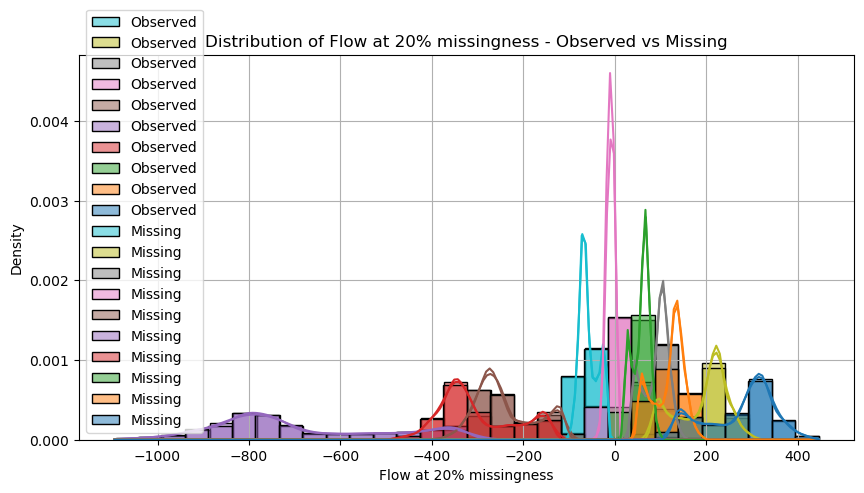

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_missing_vs_observed(data, mask, feature_name="flow"):
    """
    data: 1D array of original values
    mask: 1D boolean array, True if missing
    feature_name: for labeling
    """
    data_missing = data[mask]
    data_observed = data[~mask]

    plt.figure(figsize=(10, 5))
    sns.histplot(data_observed, color='blue', label='Observed', kde=True, stat="density", bins=30)
    sns.histplot(data_missing, color='red', label='Missing', kde=True, stat="density", bins=30)
    plt.title(f"Distribution of {feature_name} - Observed vs Missing")
    plt.xlabel(feature_name)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_missing_vs_observed(X_val_full_unscaled[0], val_masks[0][90], feature_name="Flow at 20% missingness")

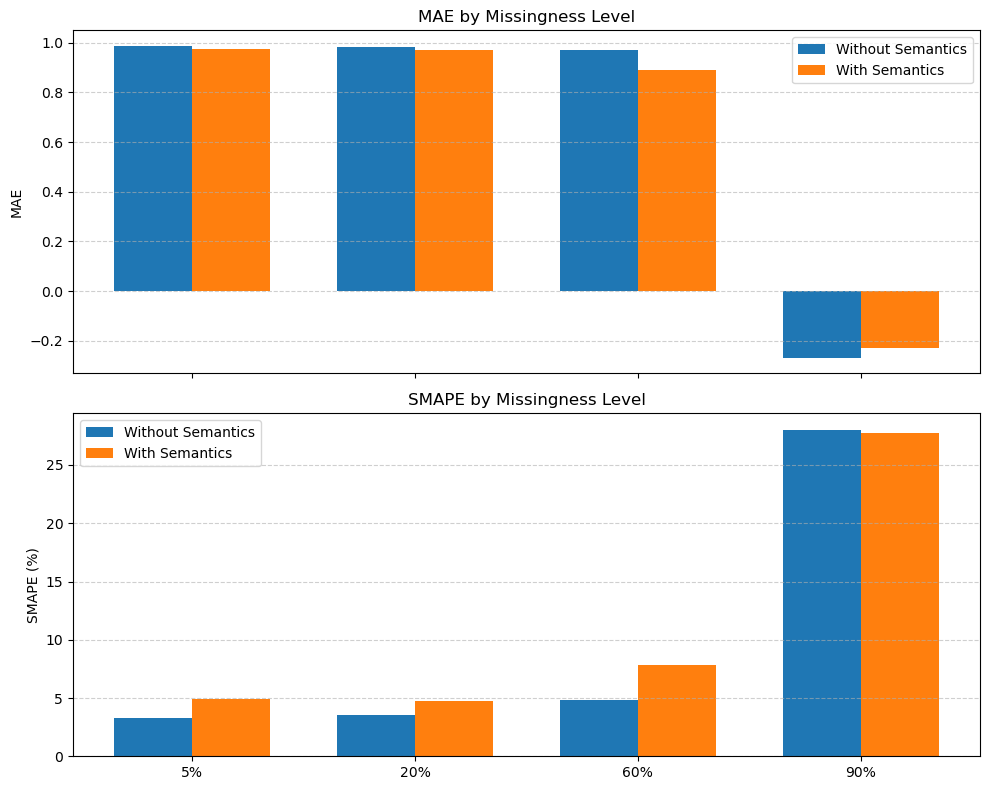

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Example error values (replace with your real variables)
missing_levels = ['5%', '20%', '60%', '90%']

# Bar chart setup
x = np.arange(len(missing_levels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- MAE plot ---
ax[0].bar(x - width/2, r2_all.values(), width, label='Without Semantics', color='tab:blue')
ax[0].bar(x + width/2, avg_r2_cluster.values(), width, label='With Semantics', color='tab:orange')
ax[0].set_ylabel('MAE')
ax[0].set_title('MAE by Missingness Level')
ax[0].legend()
ax[0].grid(True, axis='y', linestyle='--', alpha=0.6)

# --- SMAPE plot ---
ax[1].bar(x - width/2, smape_all.values(), width, label='Without Semantics', color='tab:blue')
ax[1].bar(x + width/2, avg_smape_cluster.values(), width, label='With Semantics', color='tab:orange')
ax[1].set_ylabel('SMAPE (%)')
ax[1].set_title('SMAPE by Missingness Level')
ax[1].set_xticks(x)
ax[1].set_xticklabels(missing_levels)
ax[1].legend()
ax[1].grid(True, axis='y', linestyle='--', alpha=0.6)

fig.tight_layout()
plt.show()


With MNAR, mean imputation works much worse, around 40% SMAPE. On the other hand, BRITS with all features, and MNAR on 80% of values missingness on 30% of columns with values deviated from 70% of mean, performs 22% SMAPE.
When using only semantically relevant features with same percentage as above, SMAPE is 21% so almost no improvement. It seems that best improvements, in general, come when percentage of missing data is very big, which makes other features more important thus their relevance increases.

With 100% missingness of values above 0.5 treshold (so real 50% MNAR missingness in 30% of columns), SMAPE for average is  62%. 
For BRITS with all features, it is 26,62%.
For average imputation with semantically relevant features 51%, for BRITS with semantically relevant features, it is 11,21%. AMAZING IMPROVEMENT

## probar con otro modelo mas sencillo, mirar ultima celda distance